In [129]:
import os
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import starships.planet_obs as pl_obs
from astropy import units as u
from starships import correlation as corr
from starships.orbite import rv_theo_t
from starships.planet_obs import Observations

# seed the random number generator
rstate = np.random.default_rng(736109)


In [130]:
!ls ~/scratch/DataAnalysis/SPIRou/Reductions/WASP-127b_genest

retrieval_input_3-pc_mask_wings90_tr1_data_info.npz
retrieval_input_3-pc_mask_wings90_tr1_data_trs_0.npz


In [131]:
# Use scratch if available, use home if not.
try:
    base_dir = Path(os.environ['SCRATCH'])
except KeyError:
    base_dir = Path.home()

# Where the reduced data is saved
high_res_path = base_dir / Path(f'DataAnalysis/SPIRou/Reductions/WASP-127b_genest')

# The stem of the files where the infos are saved (retrieval ready files)
high_res_file_stem = f'retrieval_input_3-pc_mask_wings90_tr1'


In [132]:
path_model_file = Path('.')
specfile = Path('WASP-127_best_fit_H2O_atmosphere.npz')


# Read the model file.
model_file = np.load(path_model_file / specfile)
wv_high, model_high = model_file['wl'], model_file['dppm']

<IPython.core.display.Javascript object>


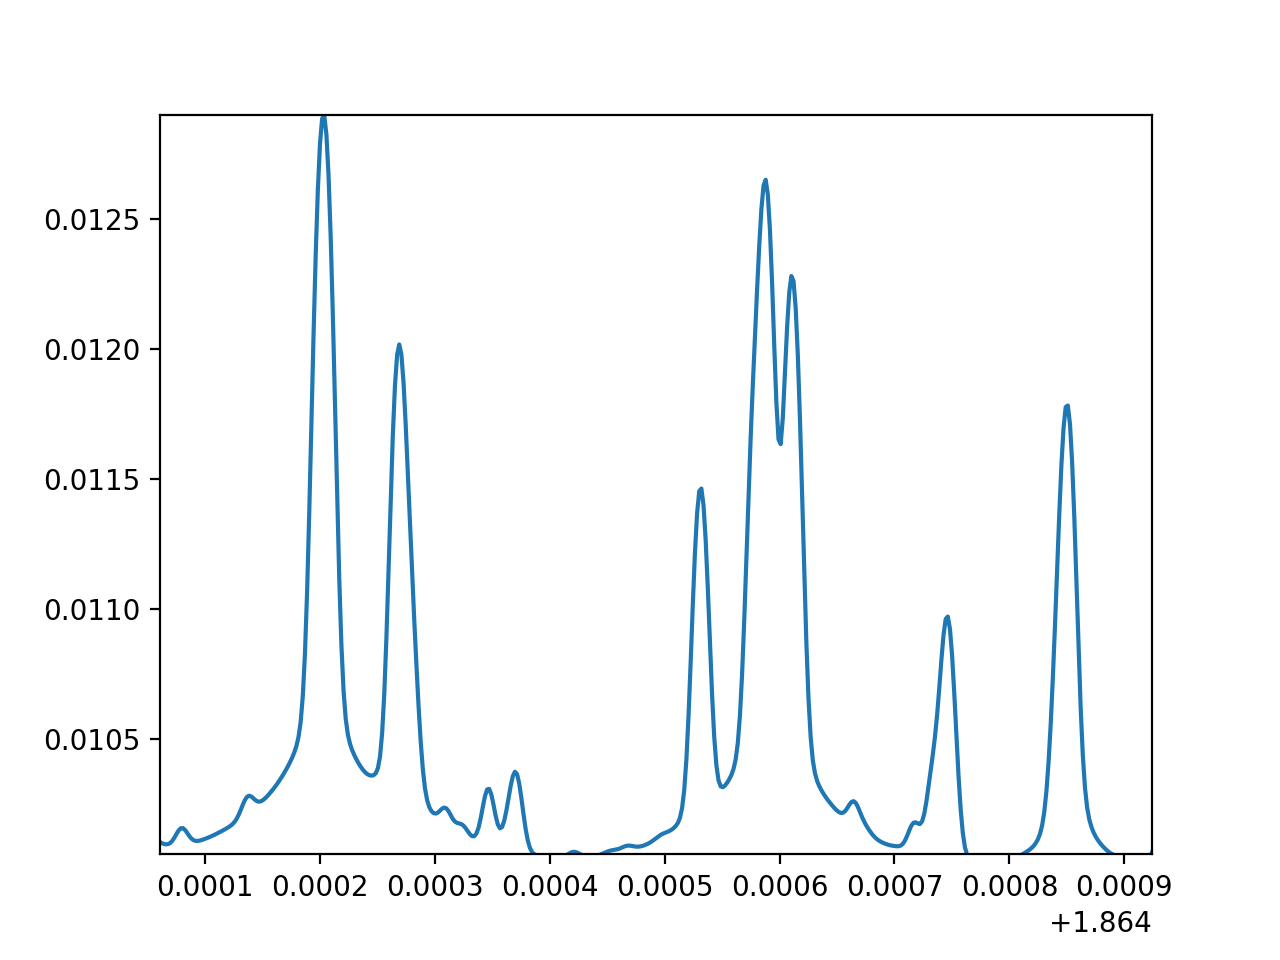

In [133]:
# QUick check
plt.plot(wv_high, model_high)

In [35]:
# %%
pl_name = 'WASP-127 b'

# --- Data parameters
pl_kwargs = {}
obs = Observations(name=pl_name, pl_kwargs=pl_kwargs)
planet = obs.planet
Kp_scale = (planet.M_pl / planet.M_star).decompose().value

Getting WASP-127 b from ExoFile


In [36]:
kind_trans = 'transmission'

# - Which sequences are taken (always take only 1)
do_tr = [1]

# - Selecting bad exposures if wanted/needed
bad_indexs = None

## --- Additionnal global variables
inj_alpha = 'ones'
idx_orders = slice(None)
nolog = True

# Choose over which axis the logl is summed.
# -1 (or equivalently 2) should always be present (sum over spectral axis)
# It is possible to sum over multiple axis, like orders and spectra
# with (-2, -1) or equivalently, (1, 2).
axis_sum = -1  # axis along which the logl is summed.

# -----------------------------------------------------------
# LOAD HIGHRES DATA
data_info, data_trs = pl_obs.load_sequences(high_res_file_stem, do_tr, path=high_res_path)
data_info['bad_indexs'] = bad_indexs

Reading: /scratch/adb/DataAnalysis/SPIRou/Reductions/WASP-127b_genest/retrieval_input_3-pc_mask_wings90_tr1_data_trs_0.npz


In [76]:
# Save (big) arrays that will be shared between processes.
# NOTE: Their values must not be changed by the processes.
out = [(obj, key) for key, obj in data_trs['0'].items()
       if isinstance(obj, np.ndarray)]
shared_arrays, shared_keys = zip(*out)  # transpose result
shared_arrays = np.array(shared_arrays, dtype=object)

# If non array objects are needed, it is better to define them separately (below)
# as global variables.
pca = data_trs['0']['pca']

# Define util functions to get the index of a key in the shared arrays.
def get_shared_array_index(*args):
    """Get the index of a key in the shared arrays"""
    idx_list = [shared_keys.index(key) for key in args]
    return idx_list
    

## Example of inject + reduced model

In [84]:
kp = 130.
v_sys = 0.


# We need from data_tr: RV_const, t_start, wave, sep, pca, params.
idx_list = get_shared_array_index('RV_const', 't_start', 'wave', 'sep', 'params')
rv_const, t_start, wave, sep, params = shared_arrays[idx_list]
    
vrp_orb = rv_theo_t(kp, t_start * u.d, planet.mid_tr,
                    planet.period, plnt=True).value
    
# Get the model sequence.
n_pc = int(params[5])
velocities = v_sys + vrp_orb - vrp_orb * Kp_scale + rv_const
model_seq = corr.gen_model_sequence_noinj(velocities,
                                          data_wave=wave,
                                          data_sep=sep,
                                          data_pca=pca,
                                          data_npc=n_pc,
                                          planet=planet,
                                          model_wave=wv_high[20:-20],
                                          model_spec=model_high[20:-20],
                                          kind_trans=kind_trans,
                                          alpha=data_info['trall_alpha_frac']
                                          )


In [95]:
data_info['trall_icorr']

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39])

In [97]:
%matplotlib notebook

<IPython.core.display.Javascript object>


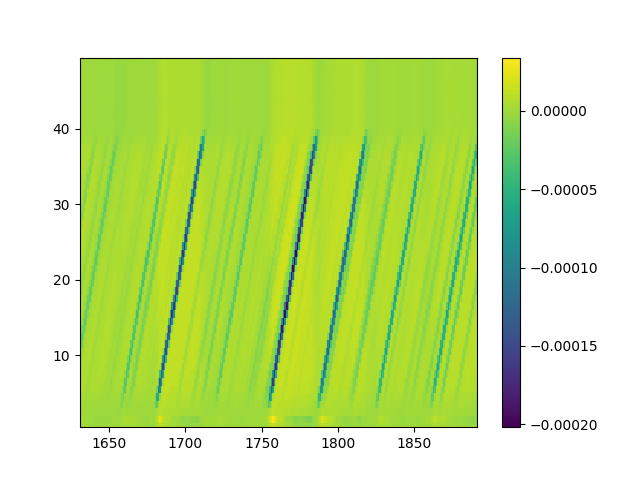

In [99]:
plt.pcolormesh(model_seq[:, 8, :])
plt.colorbar()

# Compute chi2 terms for different kp and v_sys

In [100]:
def calc_chi2_terms(model, idx_ord=None, axis=None):
    """Compute the model dependent terms of the chi2."""
    
    # Get values from global variables if not provided.
    if idx_ord is None:
        idx_ord = idx_orders
        
    if axis is None:
        axis = axis_sum
        
    # Get the index of the shared arrays and the arrays themselves.
    idx_list = get_shared_array_index('flux', 'noise')
    flux, noise = shared_arrays[idx_list]
    
    # Divide model by the uncertainty
    # NOTE: flux is already divided by the uncertainty.
    model = model[:, idx_ord] / noise[:, idx_ord]

    # Compute each terms of the chi2
    f_x_g = np.ma.sum(model * flux[:, idx_ord], axis=axis) 
    s2g = np.ma.sum(model**2, axis=axis)

    return f_x_g, s2g
    
def get_chi2_detailed(theta):
    """Return the model dependent terms of the chi2 for each exposure and each order."""
    v_sys, kp = theta

    # --- Computing the logL for all sequences
    # We need from data_tr: RV_const, t_start, wave, sep, pca, params.
    idx_list = get_shared_array_index('RV_const', 't_start', 'wave', 'sep', 'params')
    rv_const, t_start, wave, sep, params = shared_arrays[idx_list]
    
    vrp_orb = rv_theo_t(kp, t_start * u.d, planet.mid_tr,
                        planet.period, plnt=True).value
    
    
    # Get the model sequence.
    n_pc = int(params[5])
    velocities = v_sys + vrp_orb - vrp_orb * Kp_scale + rv_const
    model_seq = corr.gen_model_sequence_noinj(velocities,
                                              data_wave=wave,
                                              data_sep=sep,
                                              data_pca=pca,
                                              data_npc=n_pc,
                                              planet=planet,
                                              model_wave=wv_high[20:-20],
                                              model_spec=model_high[20:-20],
                                              kind_trans=kind_trans,
                                              alpha=data_info['trall_alpha_frac']
                                              )

    # Calculate the log likelihood.
    chi2_terms = calc_chi2_terms(model_seq)
    
    return chi2_terms

In [101]:
get_chi2_detailed(np.array([ 0, 130]))

(masked_array(
   data=[[-0.004030422243088888, -0.0029446338852057176,
          -0.0012776551532779515, ..., --, --, --],
         [-0.031901327133329785, -0.009241084194674721,
          -0.0042194824501566855, ..., --, --, --],
         [0.029168787153763608, -0.019491533369457126,
          -0.002333344021215358, ..., --, --, --],
         ...,
         [-0.0730837058649059, 0.03309001783179515, -0.05131005540631715,
          ..., --, --, --],
         [-0.0019048248336082322, -0.004095968705317348,
          0.0006177351610950326, ..., --, --, --],
         [0.023791693895656153, 0.003174307501119973,
          -0.025624607944305024, ..., --, --, --]],
   mask=[[False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, Fals

In [116]:
kp, vsys = np.meshgrid(np.linspace(40., 220., 20),
                     np.linspace(-40., 30., 40))

n_process = 2
print(f"Preparing the map with pool of {n_process} processes...")
with Pool(n_process) as pool:
    outputs = pool.map(get_chi2_detailed, np.array([np.ravel(vsys), np.ravel(kp)]).T)
outputs = np.array(outputs)
data_shape = outputs.shape[2:]
cross_terms, squared_terms = [np.reshape(outputs[:, idx], (*kp.shape, *data_shape))
                              for idx in range(2)]


Preparing the map with pool of 2 processes...


In [117]:
cross_terms.shape

(40, 20, 56, 75)

<IPython.core.display.Javascript object>


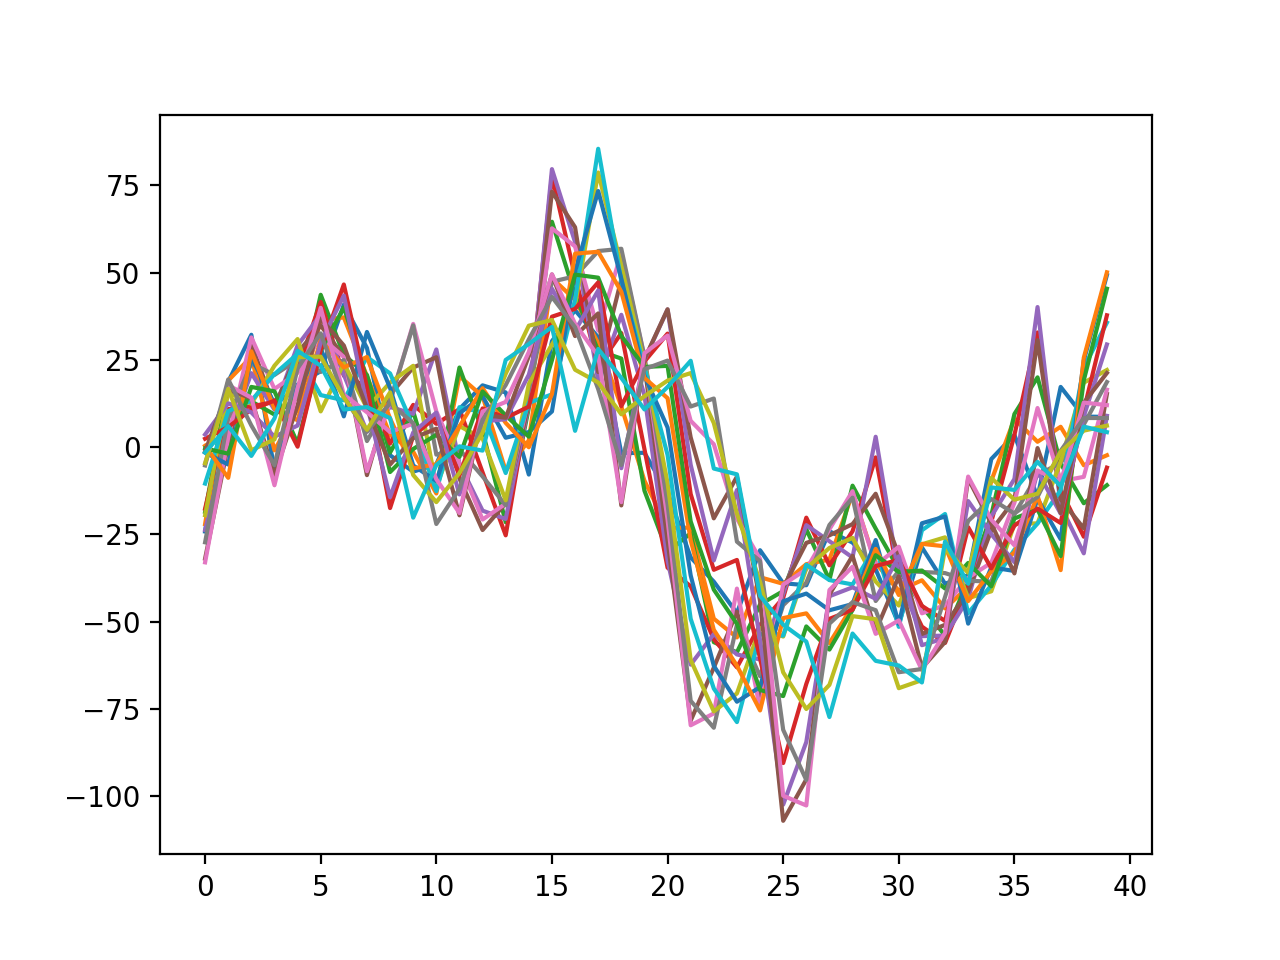

In [122]:
_ = plt.plot(cross_terms.sum(axis=(-2, -1)))

<IPython.core.display.Javascript object>


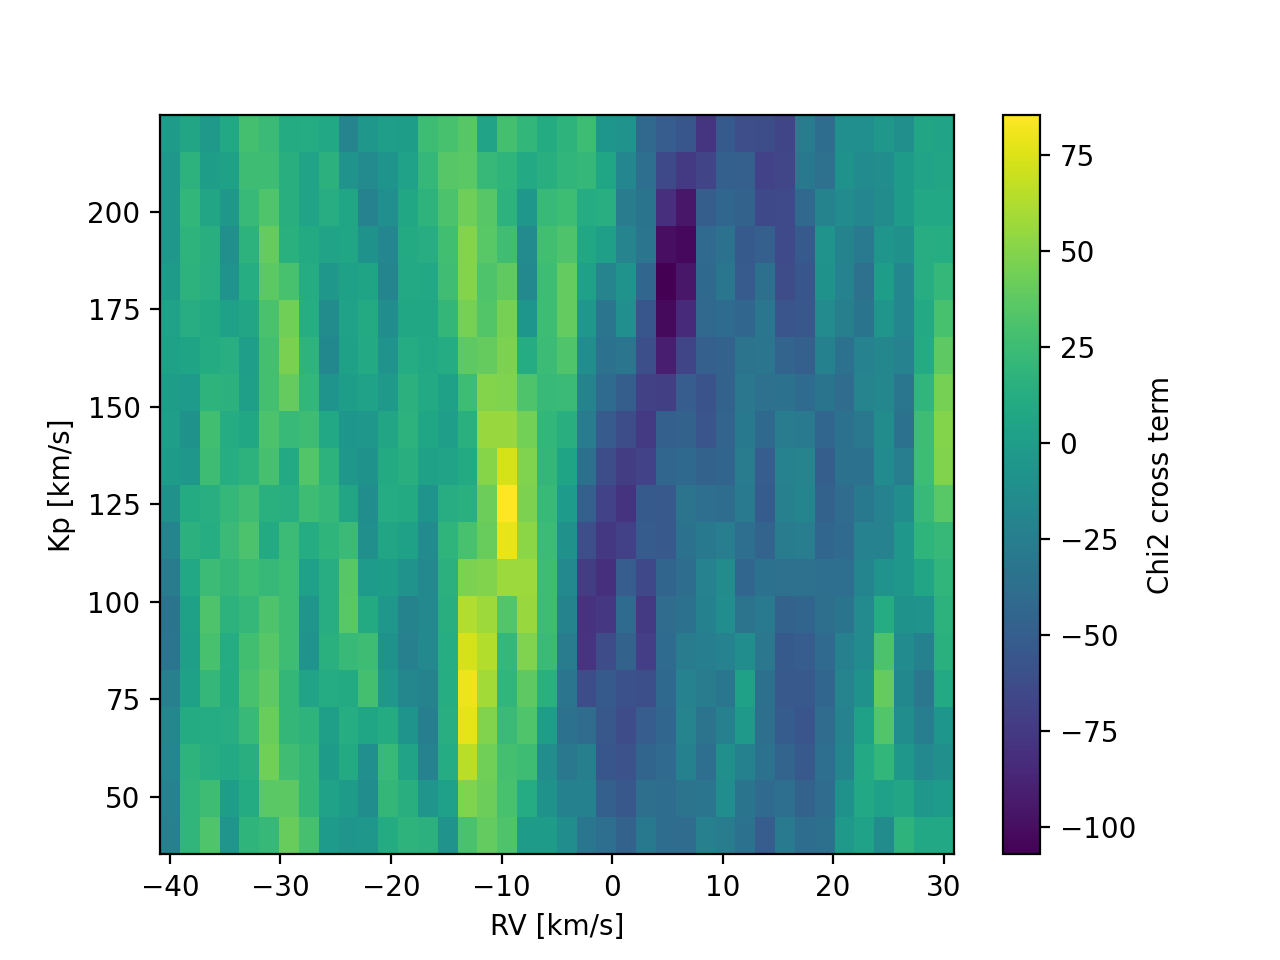

In [126]:
plt.pcolormesh(vsys, kp, cross_terms.sum(axis=(-2, -1)))
plt.ylabel('Kp [km/s]')
plt.xlabel('RV [km/s]')
plt.colorbar(label='Chi2 cross term')

# Save results for later use (time consuming to recompute)

In [127]:
# Compute useful quantities for logl computations.
for data_tr in data_trs.values():
    
    # Pre-compute all values for the logl that are independent of the model, for all orders.
    uncert_sum = np.sum(np.ma.log(data_tr['noise'][:, idx_orders]), axis=axis_sum)
    s2f= np.sum(data_tr['flux'][:, idx_orders]**2, axis=axis_sum)


# Save logl_map and kp, vsys for later use
out_path = Path('chi2_maps')

# Create the output directory if it doesn't exist.
if not out_path.exists():
    out_path.mkdir()
filename = f'chi2_map_detailed_{high_res_file_stem}.npz'
print(f"Saving to {out_path / filename}")

# Check the arrays to be saved.
saved_arrays = dict(squared_terms=squared_terms, cross_terms=cross_terms,
                    kp=kp, vsys=vsys,
                    alpha_frac=data_info['trall_alpha_frac'],
                    icorr = data_info['trall_icorr'],
                    N = data_info['trall_N'],
                    bad_indexs = data_info['bad_indexs'],
                    s2f=s2f, uncert_sum=uncert_sum)

# Make sure that all arrays are saved as empty arrays if they are not np.ndarray
# or if the dtype is object.
for key, obj in saved_arrays.items():
    if isinstance(obj, np.ndarray):
        if obj.dtype == 'object':
            print(f"{key}: {obj.shape}, {obj.dtype}")
            print(f"Saving {key} as an empty array.")
            saved_arrays[key] = np.empty(0)
    else:
        print(f"NOT AN ARRAY: type({key}): {type(obj)}")
        print(f"Saving {key} as an empty array.")
        saved_arrays[key] = np.empty(0)

np.savez(out_path / filename, **saved_arrays)

Saving to chi2_maps/chi2_map_detailed_retrieval_input_3-pc_mask_wings90_tr1.npz
NOT AN ARRAY: type(bad_indexs): <class 'NoneType'>
Saving bad_indexs as an empty array.
